In [1]:
'''
! pip install pytest -i https://mirrors.aliyun.com/pypi/simple
! pip install numba -i https://mirrors.aliyun.com/pypi/simple
! pip install h5py -i https://mirrors.aliyun.com/pypi/simple
'''

'\n! pip install pytest -i https://mirrors.aliyun.com/pypi/simple\n! pip install numba -i https://mirrors.aliyun.com/pypi/simple\n! pip install h5py -i https://mirrors.aliyun.com/pypi/simple\n'

In [2]:
import sys
from time import perf_counter
import numpy as np
import h5py
import matplotlib.pyplot as plt  
import matplotlib.mlab as mlab
import WDMWaveletTransforms.fft_funcs as fft
from WDMWaveletTransforms.wavelet_transforms import transform_wavelet_freq_time
from WDMWaveletTransforms.wavelet_transforms import transform_wavelet_time
import datetime

using mkl fft
mkl fft not available trying numpy


In [3]:
def gps_to_datetime(gps_time):
    # GPS 时间起始点（1980 年 1 月 6 日）的秒数
    gps_epoch = datetime.datetime(1980, 1, 6)
    # 将 GPS 时间加上起始点的秒数
    delta = datetime.timedelta(seconds=gps_time)
    # 计算对应的日期和时间
    datetime_utc = gps_epoch + delta
    return datetime_utc

In [4]:
file_path = 'LDC2_spritz_mbhb1_training_v1.h5'

In [5]:
# 打开.h5文件
with h5py.File(file_path, 'r') as file:
    # 获取根组
    root_group = file['/']
    
    # 遍历根组内的所有成员（包括子组和数据集）
    print("Members of the root group:")
    for name, obj in root_group.items():
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
            # 继续遍历它内部的成员
            for sub_name, sub_obj in obj.items():
                print(f"  - {sub_name}: {sub_obj}")


Members of the root group:
Group: clean
  - tdi: <HDF5 dataset "tdi": shape (535680, 1), type "|V32">
Group: header
  - date: <HDF5 dataset "date": shape (), type "|O">
Group: instru
  - config: <HDF5 group "/instru/config" (59 members)>
Group: noisefree
  - tdi: <HDF5 dataset "tdi": shape (535680, 1), type "|V32">
Group: obs
  - config: <HDF5 group "/obs/config" (104 members)>
  - tdi: <HDF5 dataset "tdi": shape (535680, 1), type "|V32">
Group: sky
  - cat: <HDF5 dataset "cat": shape (), type "|V128">
  - config: <HDF5 group "/sky/config" (21 members)>
  - tdi: <HDF5 dataset "tdi": shape (535680, 1), type "|V32">


>clean是不是代表清洁后的数据

In [6]:
#读取clean数据
data_clean = []
# 打开.h5文件
with h5py.File(file_path, 'r') as file:
    target_group = file['clean']
    for name, obj in target_group.items():
        if isinstance(obj, h5py.Dataset):
            data_clean= obj[()]

In [7]:
data_clean

array([[( 8899200.,  1.48846530e-16,  6.75330625e-17, -3.88519776e-16)],
       [( 8899205., -4.42617614e-16, -1.11055377e-16,  5.28572349e-16)],
       [( 8899210., -7.98086900e-16,  7.99285186e-16, -1.47198925e-15)],
       ...,
       [(11577585., -9.25155200e-21, -7.01214434e-21,  7.23238271e-21)],
       [(11577590.,  5.74426785e-21, -1.04391992e-21, -4.90782302e-21)],
       [(11577595., -4.26376105e-21,  8.22171527e-21,  2.00825311e-20)]],
      dtype=[('t', '<f8'), ('X', '<f8'), ('Y', '<f8'), ('Z', '<f8')])

>*t* 代表时间 *X,Y,Z*代表什么 ？？？

In [8]:
X_data = data_clean['X']
T_data= data_clean['t']

In [9]:
T0 = T_data[0][0]
T1= T_data[1][0]

In [10]:
#时间间隔为
dt = gps_to_datetime(T1) - gps_to_datetime(T0)
print(dt)

0:00:05


In [11]:
# 观察时间
print('{}天'.format(len(T_data) * 5 / (24 * 60 * 60)))

31.0天


In [12]:
X_data =X_data.flatten()#展平
T_data =T_data.flatten()#展平

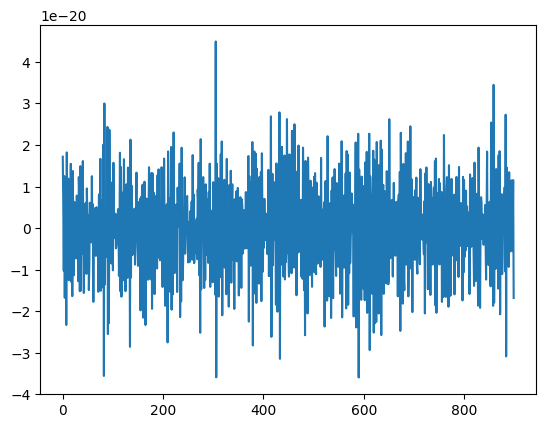

In [13]:
plt.plot(X_data[100:1000])

/root/miniconda3/envs/cuda_learning/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/root/miniconda3/envs/cuda_learning/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


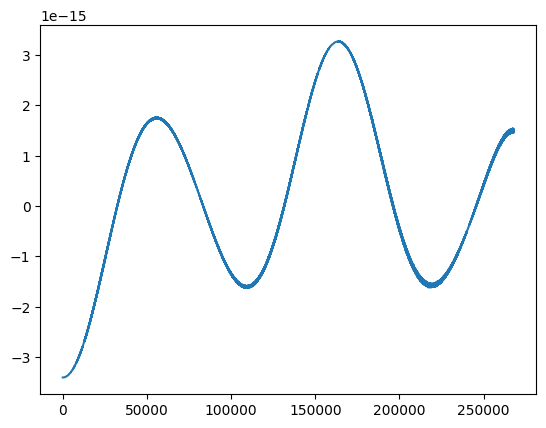

In [35]:
plt.plot(fft.rfft(X_data))

In [15]:
Tobs = 31*21*60*60 #31天
delta_F = 0.01 #10mHz
dt = 5.
Nf = np.sqrt(Tobs/delta_F)/(4*dt)
Nt = 4*np.sqrt(delta_F*Tobs)

$N_{f}\simeq \sqrt{T_{obs}/\bigtriangleup F}/{4dt}$ 

$N_{t}\simeq 4\sqrt{\bigtriangleup F T_{obs}}$

参考文章：Digman, M. C. and Cornish, N. J., “Parameter estimation for stellar-origin black hole mergers in LISA”, <i>Physical Review D</i>, vol. 108, no. 2, APS, 2023. doi:10.1103/PhysRevD.108.023022.

In [33]:
dt = np.float64(5.)
Nf = np.int64(Nf)
Nt = np.int64(Nt)
mult = np.int64(16)

signal_time = X_data

ND = Nt*Nf

x = np.linspace(0, 31, Nf)
y = np.linspace(-21, -17, Nt)
X, Y = np.meshgrid(x, y)

wave_time = transform_wavelet_freq_time(signal_time,Nf,Nt,mult)
wave = np.log10(abs(wave_time))

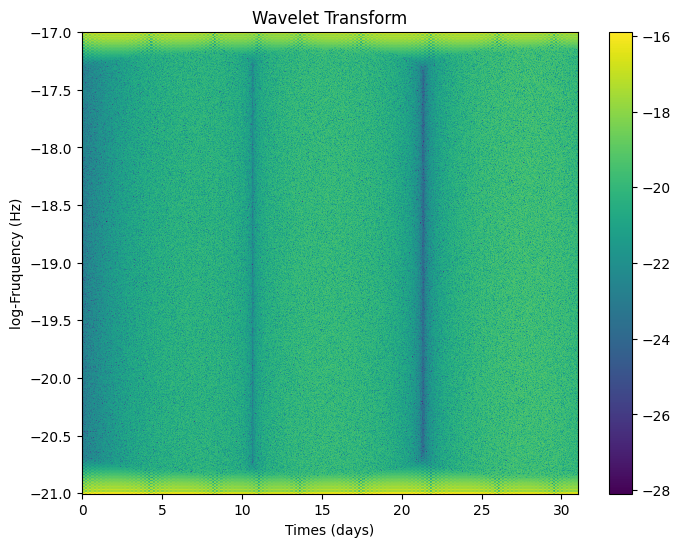

In [34]:
# 绘制小波变换结果的伪彩色图
plt.figure(figsize=(8, 6))
plt.pcolormesh(X,Y,wave)
plt.colorbar()  # 添加颜色条
plt.title('Wavelet Transform')
plt.xlabel('Times (days)')
plt.ylabel('log-Fruquency (Hz)')
plt.show()